**Trade Data Analysis UNI/WETH**



1.   First we will import necessary libraries/packages
2.   Also please use playground in https://thegraph.com/explorer/subgraph/uniswap/uniswap-v2  to get better idea of API



In [285]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
pd.plotting.register_matplotlib_converters()



3.   Now we are going to write graphql query to access our pool data.

4. We have randomly selected a time and date on 15th june and   
converted it to timestamp and then used that as starting timestamp.

5. Then we will get 1000 entries for first swap and skip 1000 for other two to get whole weeks trading data.







In [286]:

a="""query trades{
     s1: swaps(first:1000, orderBy: timestamp,orderDirection:asc,where:{pair: "0xd3d2e2692501a5c9ca623199d38826e513033a17",timestamp_gt:1623780188}) {
      id 
      timestamp
      amount0In 
      amount1In
      amount0Out
      amount1Out
      pool:pair 
      {
        id 
        volumeUSD  
        UNI: token0 {
        totalLiquidity
        }
        WETH: token1 {
        totalLiquidity
        }
      }
      transaction{
        id
        blockNumber
      }
  },
 s2: swaps(first:1000 ,skip:1000, orderBy: timestamp,orderDirection:asc,where:{pair: "0xd3d2e2692501a5c9ca623199d38826e513033a17",timestamp_gt:1623780188}) {
      id 
      timestamp
      amount0In 
      amount1In
      amount0Out
      amount1Out
      pool:pair 
      {
        id 
        volumeUSD  
        UNI: token0 {
        totalLiquidity
        }
        WETH: token1 {
        totalLiquidity
        }
      }
      transaction{
        id
        blockNumber
      }
  },
  s3:swaps(first:1000,skip:2000, orderBy: timestamp,orderDirection:asc,where:{pair: "0xd3d2e2692501a5c9ca623199d38826e513033a17",timestamp_gt:1623780188}) {
      id 
      timestamp
      amount0In 
      amount1In
      amount0Out
      amount1Out
      pool:pair 
      {
        id 
        volumeUSD  
        UNI: token0 {
        totalLiquidity
        }
        WETH: token1 {
        totalLiquidity
        }
      }
      transaction{
        id
        blockNumber
      }
  }
  
  
    }"""


In [287]:
url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2'
r = requests.post(url, json={'query': a})
print(r.status_code)
print(r.text)

200
{"data":{"s1":[{"amount0In":"2087.264597703946647741","amount0Out":"0","amount1In":"0","amount1Out":"19.1461","id":"0x494109cc9cfce7dd190b426e507f3320720976c7afc9e7b1c80ca1c1bb2b6072-0","pool":{"UNI":{"totalLiquidity":"2340786.931315991203219354"},"WETH":{"totalLiquidity":"748149.943227705158481776"},"id":"0xd3d2e2692501a5c9ca623199d38826e513033a17","volumeUSD":"6633440632.626017531257606826696773"},"timestamp":"1623780202","transaction":{"blockNumber":"12640567","id":"0x494109cc9cfce7dd190b426e507f3320720976c7afc9e7b1c80ca1c1bb2b6072"}},{"amount0In":"0","amount0Out":"4.31677012059440042","amount1In":"0.0398","amount1Out":"0","id":"0x71073332c662ee231838c49a9f79213c01670106dab6541550420d15a0c13403-0","pool":{"UNI":{"totalLiquidity":"2340786.931315991203219354"},"WETH":{"totalLiquidity":"748149.943227705158481776"},"id":"0xd3d2e2692501a5c9ca623199d38826e513033a17","volumeUSD":"6633440632.626017531257606826696773"},"timestamp":"1623780386","transaction":{"blockNumber":"12640579","id"



6.   loading api response as JSON
7.   Adding all data to DataFrame



In [308]:
json_data = json.loads(r.text)["data"]
jd1=(pd.json_normalize(json_data["s1"]))
jd2=(pd.json_normalize(json_data["s2"]))
jd3=(pd.json_normalize(json_data["s3"]))
df=jd1.append(jd2)
df=df.append(jd3)
display(df)
print(len(df.index))
tdf=df

,amount0In,amount0Out,amount1In,amount1Out,id,timestamp,pool.UNI.totalLiquidity,pool.WETH.totalLiquidity,pool.id,pool.volumeUSD,transaction.blockNumber,transaction.id
0,2087.264597703946647741,0,0,19.1461,0x494109cc9cfce7dd190b426e507f3320720976c7afc9...,1623780202,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640567,0x494109cc9cfce7dd190b426e507f3320720976c7afc9...
1,0,4.31677012059440042,0.0398,0,0x71073332c662ee231838c49a9f79213c01670106dab6...,1623780386,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640579,0x71073332c662ee231838c49a9f79213c01670106dab6...
2,40.551148971901641393,0,0,0.371630118032970347,0xe00bbce95d4b4cdedcc44a741017e49a219b11792339...,1623780763,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640609,0xe00bbce95d4b4cdedcc44a741017e49a219b11792339...
3,1.742913762135109279,0,0,0.015972605215584912,0x297a2fd6341dc46921b8f800bae0c935c9ec4b8cd6ac...,1623781062,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640636,0x297a2fd6341dc46921b8f800bae0c935c9ec4b8cd6ac...
4,0,5.097857492340997622,0.047,0,0x5cf7452d0b7601fb3458f0e3138eb3ba145ee14abfd4...,1623781090,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640638,0x5cf7452d0b7601fb3458f0e3138eb3ba145ee14abfd4...
...,...,...,...,...,...,...,...,...,...,...,...,...
666,2.739,0,0,0.023938283367062342,0x71c292c13656ab3a0eafbd85b8e5315fd666646f4e79...,1624395134,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12686300,0x71c292c13656ab3a0eafbd85b8e5315fd666646f4e79...
667,0,7316.716645554444791745,64.536121944692704461,0,0xec15bad25b7f28096ab4e8c0c30798f995e79252521d...,1624395355,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12686319,0xec15bad25b7f28096ab4e8c0c30798f995e79252521d...
668,52.566654646583655443,0,0,0.462252794458694975,0x79e47ec192f3e8826be7d7094605f37aaa7425dce127...,1624395366,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12686321,0x79e47ec192f3e8826be7d7094605f37aaa7425dce127...
669,208.592355514081804288,0,0,1.834496009642698901,0xbea56f52621a2772e29ee38470982c5a962c70f808e9...,1624395366,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12686321,0xbea56f52621a2772e29ee38470982c5a962c70f808e9...


2671


 
 8. Our Data will be further modified to get only desirable columns and all those columns will be further modified to get consumable dataframe.



In [309]:
df['UNI'] = np.where(df['amount0In']!= '0', 'SELL','BUY')
df['WETH'] = np.where(df['amount1In']!= '0', 'SELL','BUY')

df[["amount0In","amount0Out",'amount1In',"amount1Out","timestamp"]] = df[["amount0In","amount0Out",'amount1In',"amount1Out","timestamp"]].apply(pd.to_numeric)

df['UNI_traded']=np.where(df['UNI']=='BUY',df['amount0Out'],df['amount0In']*-1)
df['WETH_traded']=np.where(df['WETH']=='BUY',df['amount1Out'],df['amount1In']*-1)


df['date']=df.apply(lambda row: datetime.fromtimestamp(row.timestamp).date(),axis=1)
df['time']=df.apply(lambda row: datetime.fromtimestamp(row.timestamp).time(),axis=1)

df=df.drop(columns=["amount0In","amount1In","amount0Out","amount1Out"])
display(df)


,id,timestamp,pool.UNI.totalLiquidity,pool.WETH.totalLiquidity,pool.id,pool.volumeUSD,transaction.blockNumber,transaction.id,UNI,WETH,UNI_traded,WETH_traded,date,time
0,0x494109cc9cfce7dd190b426e507f3320720976c7afc9...,1623780202,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640567,0x494109cc9cfce7dd190b426e507f3320720976c7afc9...,SELL,BUY,-2087.264598,19.146100,2021-06-15,18:03:22
1,0x71073332c662ee231838c49a9f79213c01670106dab6...,1623780386,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640579,0x71073332c662ee231838c49a9f79213c01670106dab6...,BUY,SELL,4.316770,-0.039800,2021-06-15,18:06:26
2,0xe00bbce95d4b4cdedcc44a741017e49a219b11792339...,1623780763,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640609,0xe00bbce95d4b4cdedcc44a741017e49a219b11792339...,SELL,BUY,-40.551149,0.371630,2021-06-15,18:12:43
3,0x297a2fd6341dc46921b8f800bae0c935c9ec4b8cd6ac...,1623781062,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640636,0x297a2fd6341dc46921b8f800bae0c935c9ec4b8cd6ac...,SELL,BUY,-1.742914,0.015973,2021-06-15,18:17:42
4,0x5cf7452d0b7601fb3458f0e3138eb3ba145ee14abfd4...,1623781090,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640638,0x5cf7452d0b7601fb3458f0e3138eb3ba145ee14abfd4...,BUY,SELL,5.097857,-0.047000,2021-06-15,18:18:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,0x71c292c13656ab3a0eafbd85b8e5315fd666646f4e79...,1624395134,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12686300,0x71c292c13656ab3a0eafbd85b8e5315fd666646f4e79...,SELL,BUY,-2.739000,0.023938,2021-06-22,20:52:14
667,0xec15bad25b7f28096ab4e8c0c30798f995e79252521d...,1624395355,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12686319,0xec15bad25b7f28096ab4e8c0c30798f995e79252521d...,BUY,SELL,7316.716646,-64.536122,2021-06-22,20:55:55
668,0x79e47ec192f3e8826be7d7094605f37aaa7425dce127...,1624395366,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12686321,0x79e47ec192f3e8826be7d7094605f37aaa7425dce127...,SELL,BUY,-52.566655,0.462253,2021-06-22,20:56:06
669,0xbea56f52621a2772e29ee38470982c5a962c70f808e9...,1624395366,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12686321,0xbea56f52621a2772e29ee38470982c5a962c70f808e9...,SELL,BUY,-208.592356,1.834496,2021-06-22,20:56:06


9. Creating a second duplicate dataframe where UNI_traded and WETH_traded are not negative to show selling.This is for ease in visulization. 

In [310]:
tdf[["amount0In","amount0Out",'amount1In',"amount1Out","timestamp"]] = tdf[["amount0In","amount0Out",'amount1In',"amount1Out","timestamp"]].apply(pd.to_numeric)
tdf['UNI'] = np.where(tdf['amount0In']!= 0, 'SELL','BUY')
tdf['WETH'] = np.where(tdf['amount1In']!= 0, 'SELL','BUY')

tdf['UNI_traded']=np.where(tdf['UNI']=='BUY',tdf['amount0Out'],tdf['amount0In'])
tdf['WETH_traded']=np.where(tdf['WETH']=='BUY',tdf['amount1Out'],tdf['amount1In'])


tdf['date']=tdf.apply(lambda row: datetime.fromtimestamp(row.timestamp).date().strftime("%d"),axis=1)
tdf['time']=tdf.apply(lambda row: datetime.fromtimestamp(row.timestamp).time().strftime("%H:%M"),axis=1)

tdf=tdf.drop(columns=["amount0In","amount1In","amount0Out","amount1Out"])


In [311]:
display(tdf.head())

,id,timestamp,pool.UNI.totalLiquidity,pool.WETH.totalLiquidity,pool.id,pool.volumeUSD,transaction.blockNumber,transaction.id,UNI,WETH,UNI_traded,WETH_traded,date,time
0,0x494109cc9cfce7dd190b426e507f3320720976c7afc9...,1623780202,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640567,0x494109cc9cfce7dd190b426e507f3320720976c7afc9...,SELL,BUY,2087.264598,19.146100,15,18:03
1,0x71073332c662ee231838c49a9f79213c01670106dab6...,1623780386,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640579,0x71073332c662ee231838c49a9f79213c01670106dab6...,BUY,SELL,4.316770,0.039800,15,18:06
2,0xe00bbce95d4b4cdedcc44a741017e49a219b11792339...,1623780763,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640609,0xe00bbce95d4b4cdedcc44a741017e49a219b11792339...,SELL,BUY,40.551149,0.371630,15,18:12
3,0x297a2fd6341dc46921b8f800bae0c935c9ec4b8cd6ac...,1623781062,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640636,0x297a2fd6341dc46921b8f800bae0c935c9ec4b8cd6ac...,SELL,BUY,1.742914,0.015973,15,18:17
4,0x5cf7452d0b7601fb3458f0e3138eb3ba145ee14abfd4...,1623781090,2340786.931315991203219354,748149.943227705158481776,0xd3d2e2692501a5c9ca623199d38826e513033a17,6633440632.626017531257606826696773,12640638,0x5cf7452d0b7601fb3458f0e3138eb3ba145ee14abfd4...,BUY,SELL,5.097857,0.047000,15,18:18


**Visualizations and Inference**

We will visualize our dataframes and draw some inferences from them.



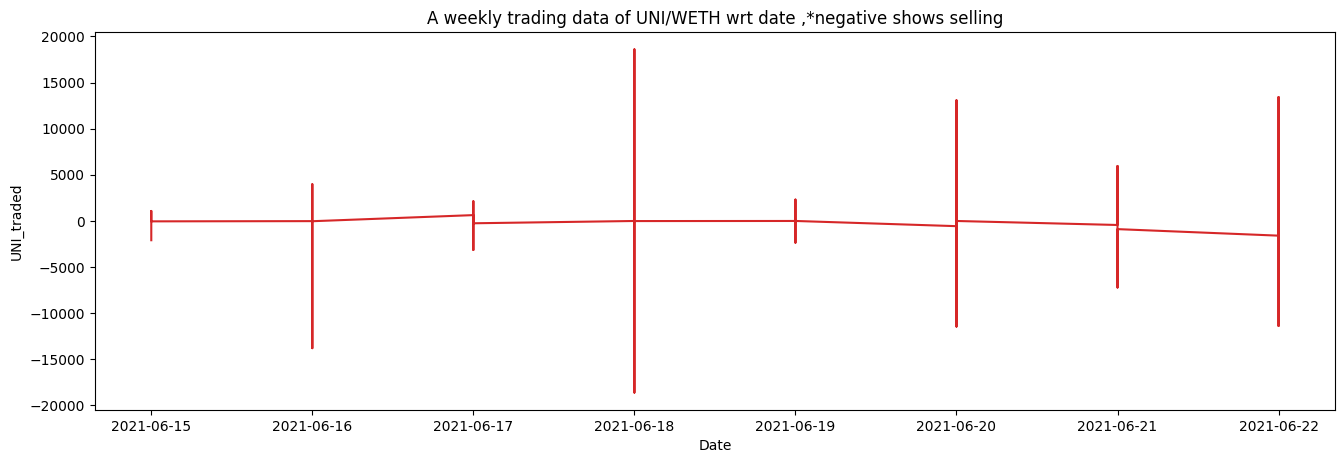

In [313]:
def plot_df(df,x,y,title="", xlabel='Date', ylabel='UNI_traded', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.date,y=df.UNI_traded, title='A weekly trading data of UNI/WETH wrt date ,*negative shows selling')

Above we can see that there us almost equal amount of UNI buying and selling most days.
There wa highest and lowest trading amount on 18/06

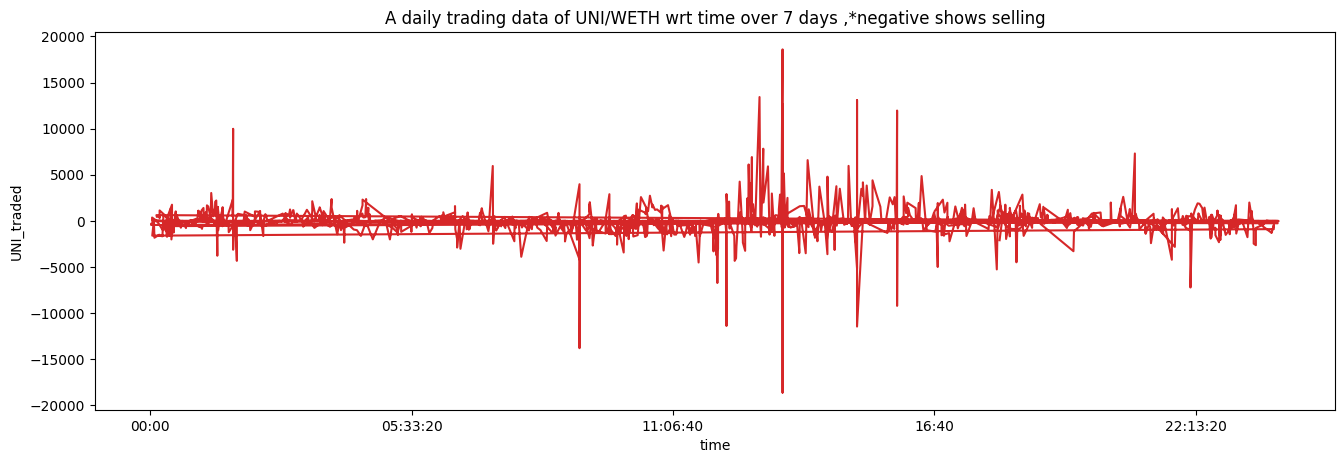

In [291]:
def plot_df(df,x,y,title="", xlabel='time', ylabel='UNI_traded', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.time,y=df.UNI_traded, title='A daily trading data of UNI/WETH wrt time over 7 days ,*negative shows selling')

Above we can see thatmost trading happens between 11 am to 16 pm 
with voltality being high during this period.

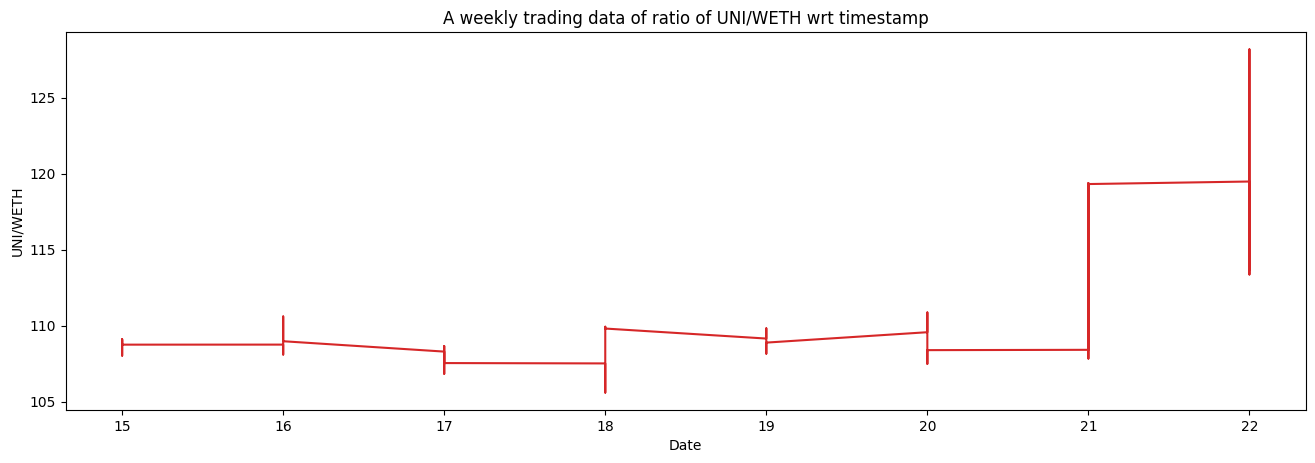

In [314]:
def plot_df(tdf,x,y,title="", xlabel='Date', ylabel='UNI/WETH', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(tdf, x=tdf.date,y=tdf.UNI_traded/tdf.WETH_traded, title='A weekly trading data of ratio of UNI/WETH wrt timestamp')   

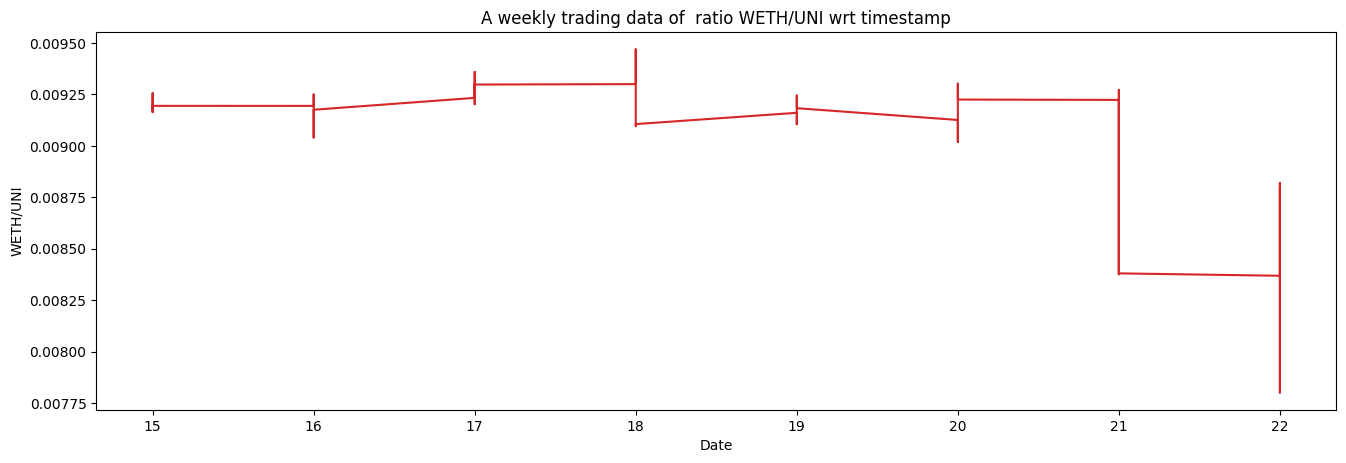

In [315]:
def plot_df(tdf,x,y,title="", xlabel='Date', ylabel='WETH/UNI', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(tdf, x=tdf.date,y=tdf.WETH_traded/tdf.UNI_traded, title='A weekly trading data of  ratio WETH/UNI wrt timestamp')   

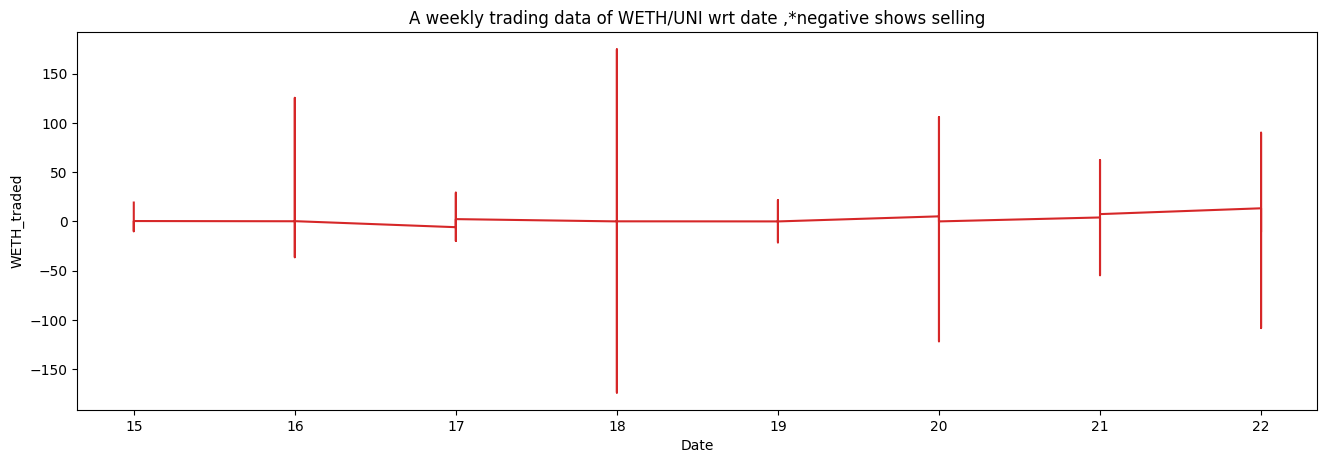

In [283]:
def plot_df(df,x,y,title="", xlabel='Date', ylabel='WETH_traded', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.date,y=df.WETH_traded, title='A weekly trading data of WETH/UNI wrt date ,*negative shows selling')

As with UNI,WETH also shows most stark differences between selling and buying amount on 18th.

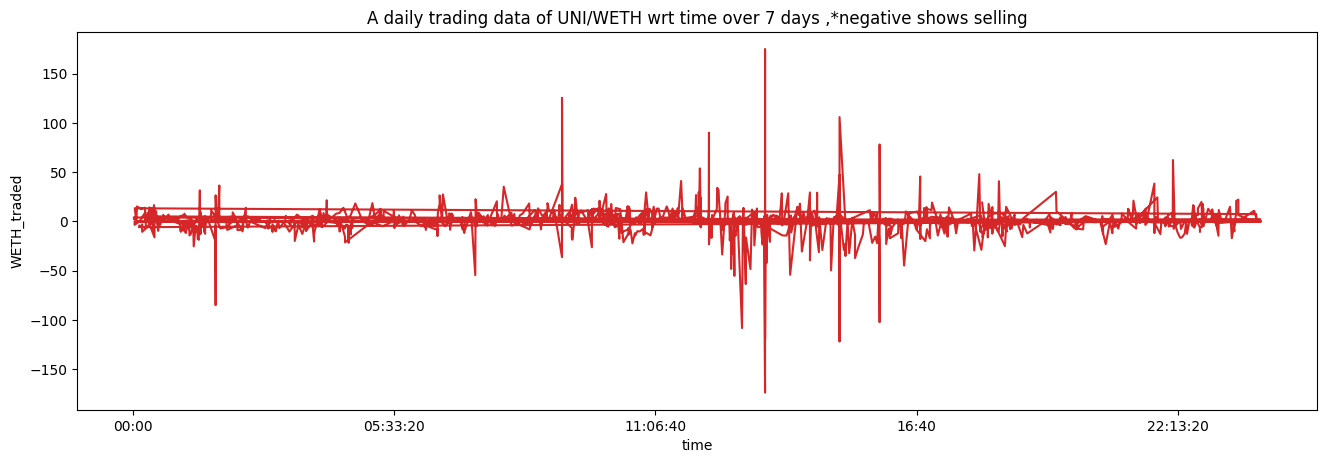

In [284]:
def plot_df(df,x,y,title="", xlabel='time', ylabel='WETH_traded', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.time,y=df.WETH_traded, title='A daily trading data of UNI/WETH wrt time over 7 days ,*negative shows selling')

Same as above UNI time graph ,WETH shows most trading and voltality happeing between 11 am and 16 pm.

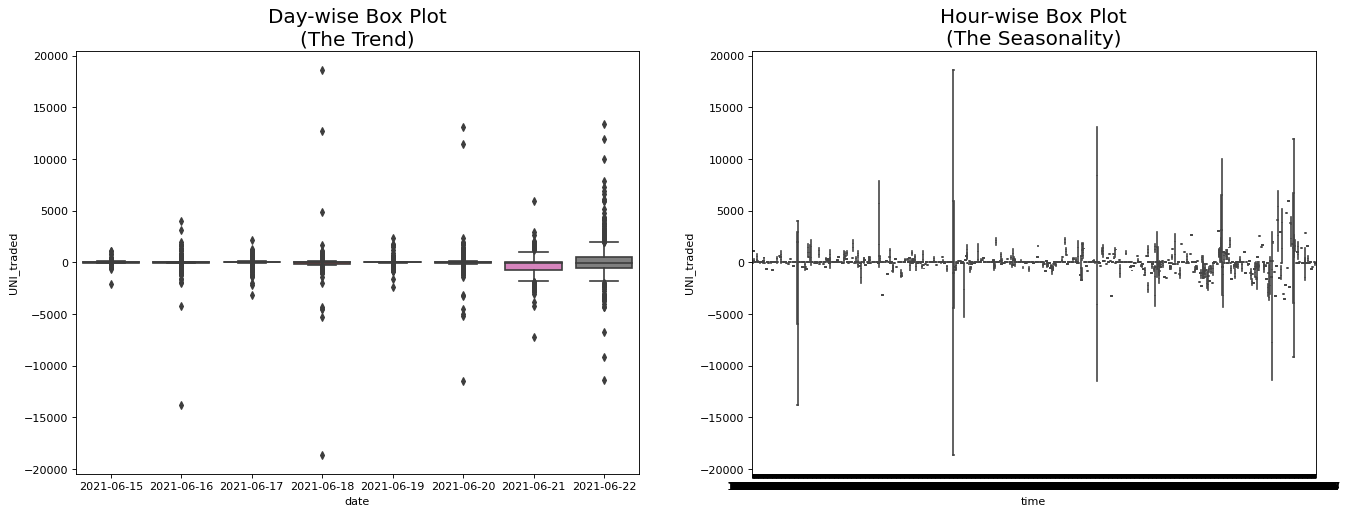

In [322]:

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='date', y='UNI_traded', data=df, ax=axes[0])
sns.boxplot(x='time', y='UNI_traded', data=df,ax=axes[1])

# Set Title
axes[0].set_title('Day-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Hour-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()